Checkbox testing
converted: 20 349 128 277


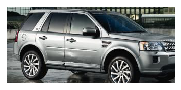

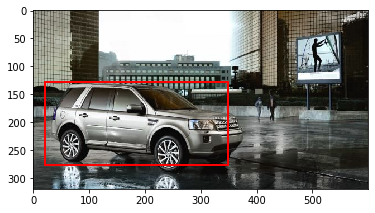

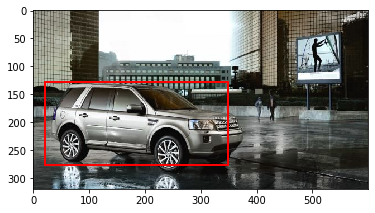

In [4]:
import torchvision.models
from fastai import *
from fastai.vision import load_learner, open_image, show_image
from tkinter import filedialog
import torch
import torch.utils.data as data
import fastai
import torchvision.models
import warnings; warnings.filterwarnings('ignore')
import torch
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import cv2
import matplotlib.patches as patches
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import load_model
import numpy as np

def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

######################################################################################


root=tk.Tk()
root.title('AIML Capstone Group 1 - Car Identification Model')
root.geometry('1600x1600')

row = 1
explanation = """The models mentioned here would classify the uploaded image to one of the 196 classes of car.
There are 4 options to choose the model for classification and regression each. Upload the image after selecting the model. 
"""

w2 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text="Welcome to the presentation of AIML Group 1.",font=("Arial", 20),fg='blue')
w2.grid(row=1, column = 0, rowspan = 1, columnspan = 3, sticky=tk.W)

w2 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text=explanation,font=("Arial", 15))
w2.grid(row=3, column = 0, rowspan = 1, columnspan = 3, sticky=tk.W)

var1 = tk.IntVar()
c1 = tk.Checkbutton(root, text='Select if Classification on cropped images(based on BB) is required.',variable=var1, onvalue=1, offvalue=0,font=("Arial", 15),fg='blue')
c1.grid(row=5,column=0,rowspan = 1, columnspan = 2, sticky=tk.W)
w3 = tk.Label(root, 
              justify=tk.LEFT,
               
              text="Please choose the Classification model for prediction:",font=("Arial", 15),fg='blue')
w3.grid(row=7,column=0,rowspan = 1, columnspan = 2, sticky=tk.W)

v0=tk.StringVar()
v0.set('Resnet152_90percent.pkl')
r1=ttk.Radiobutton(root, text="Resnet152 - Accuracy on Test - 90%(Top 1)", variable=v0,value='Resnet152_90percent.pkl')
r2=ttk.Radiobutton(root, text="Densenet201 - Accuracy on Test - 89%(Top 1)", variable=v0,value='Densenet201_89percent.pkl')
r3=ttk.Radiobutton(root, text="Densenet121 - Accuracy on Test - 87%(Top 1)", variable=v0,value='Densenet121_87percent.pkl')
r4=ttk.Radiobutton(root, text="Mobilenetv2 - Accuracy on Test - 84%(Top 1)", variable=v0,value='Mobilenetv2_84percent.pkl')
r1.grid(row=9,column=0,rowspan = 1, columnspan = 1, sticky=tk.W)
r2.grid(row=10,column=0,rowspan = 1, columnspan = 1, sticky=tk.W)
r3.grid(row=11,column=0,rowspan = 1, columnspan = 1, sticky=tk.W)
r4.grid(row=12,column=0,rowspan = 2, columnspan = 1, sticky=tk.W)


w3 = tk.Label(root, 
              justify=tk.LEFT,
             
              text="Please choose the Regression model for BB prediction:",font=("Arial", 15),fg='blue')
w3.grid(row=7,column=2,rowspan = 1, columnspan = 2, sticky=tk.W)
v1=tk.StringVar()
v1.set('Mobilenet_Regression_92percent.h5')
r5=ttk.Radiobutton(root, text="Mobilenet BB Prediction - IoU on Test - 92% ", variable=v1,value='Mobilenet_Regression_92percent.h5')
r6=ttk.Radiobutton(root, text="Resnet BB Prediction - IoU on Test - 91% ", variable=v1,value='Resnet_Regression_91percent.h5')
r7=ttk.Radiobutton(root, text="XceptionNet BB Prediction - IoU on Test - 91% ", variable=v1,value='XceptionNet_Regression_91percent.h5')
r8=ttk.Radiobutton(root, text="Densenet BB Prediction - IoU on Test - 83% ", variable=v1,value='Densenet_Regression_83percent.h5')

r5.grid(row=9,column=2,rowspan = 1, columnspan = 1, sticky=tk.W)
r6.grid(row=10,column=2,rowspan = 1, columnspan = 1, sticky=tk.W)
r7.grid(row=11,column=2,rowspan = 1, columnspan = 1, sticky=tk.W)
r8.grid(row=12,column=2,rowspan = 2, columnspan = 1, sticky=tk.W)

w4 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text="Please select the image:",font=("Arial", 15),fg='blue')
w4.grid(row=23,column=0,rowspan = 1, columnspan = 1, sticky=tk.W)

Image_var=tk.StringVar()
Image_entrybox=ttk.Entry(root,width=16,textvariable=Image_var)
Image_entrybox.grid(row=24,column=1,rowspan = 2, columnspan = 1, sticky=tk.W)



def top_5_preds(preds):    
    preds_s = preds.argsort(descending=True)
    preds_s=preds_s[:5]
    return preds_s
def top_5_pred_labels(preds, classes):
    top_5 = top_5_preds(preds)
    labels = []
    confidence=[]
    for i in top_5:
        x=classes[i]
        p=preds[i]
        labels.append(x)
        confidence.append(p)
    return labels,confidence

def browseFiles():
    
    filename = filedialog.askopenfilename(initialdir = "/",
                                          title = "Select a File",
                                          filetypes = (("Images",
                                                        "*.jpg"),
                                                       ("Images",
                                                        "*.jpeg")))
      
    


    
    ## Loading the corresponding models
    
    model_inf = load_learner('./Models',v0.get())
    regloc='./models/'+ v1.get()
    modelReg = load_model(regloc, custom_objects={"IoU": IoU})
    
    ## Predicting the bounding box
    IMAGE_SIZE=128
    unscaled = cv2.imread(filename) # Original image for display
    image_height, image_width, _ = unscaled.shape
    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
    region = modelReg.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

    x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
    y0 = int(region[1] * image_height / IMAGE_SIZE)

    x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)
    
    # processing for classification
    image= open_image(filename)
    ###########################################

    #a0=int(x0*IMAGE_SIZE/image.size[1])
    #a1=int(x1*IMAGE_SIZE/image.size[1])
    #b0=int(y0*IMAGE_SIZE/image.size[0])
    #b1=int(y1*IMAGE_SIZE/image.size[0])
    
    if (var1.get() == 1):
        print("Checkbox testing")
        image_height=image.size[0]
        image_width= image.size[1]
        x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
        y0 = int(region[1] * image_height / IMAGE_SIZE)

        x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
        y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

        print("converted:",x0,x1,y0,y1)
        image.px = image.px[:,y0:y1,x0:x1]
        show_image(image)
    
    
    ##########################################
    pred_class,pred_idx,probs=model_inf.predict(image)
    confidence = str(float(probs[int(pred_class)])*100)
    w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text="Prediction :", font=("Arial", 20),fg='blue')
    w3.grid(row=27,column=0,rowspan = 1, columnspan = 1, sticky=tk.W)
    
    w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text= model_inf.data.classes[int(pred_class)], font=("Arial", 20))
    w3.grid(row=27,column=1,rowspan = 1, columnspan = 1, sticky=tk.W)
    
    w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text="Confidence :", font=("Arial", 20),fg='blue')
    w3.grid(row=30,column=0,rowspan = 2, columnspan = 1, sticky=tk.W)
    
    w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text= confidence, font=("Arial", 20))
    w3.grid(row=30,column=1,rowspan = 2, columnspan = 1, sticky=tk.W)
    
    classes=model_inf.data.classes
    top_5_predictions,top_5_confidence=top_5_pred_labels(probs,classes)
    w3 = tk.Label(root, 
              justify=tk.LEFT,
              
              text="Top 5 predictions", font=("Arial", 20),fg='blue')
    w3.grid(row=33,column=0,rowspan = 2, columnspan = 1, sticky=tk.W)
    w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text="Class", font=("Arial", 15),fg='blue')
    w3.grid(row=35,column=0,rowspan = 1, columnspan = 2, sticky=tk.W)
    w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text="Confidence", font=("Arial", 15),fg='blue')
    w3.grid(row=35,column=1,rowspan = 1, columnspan = 2, sticky=tk.W)

    row=0
    for x in range(5):
        w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text=top_5_predictions[x], font=("Arial", 15),fg='black')
        w3.grid(row=39+row,column=0,rowspan = 1, columnspan = 2, sticky=tk.W)
        w3 = tk.Label(root, 
              justify=tk.LEFT,
              padx = 10, 
              text=str(float(top_5_confidence[x])*100), font=("Arial", 15),fg='black')
        w3.grid(row=39+row,column=1,rowspan = 1, columnspan = 2, sticky=tk.W)
        row=row+1
    
    #Regression model for boundary boxes
    #regloc='./models/'+ v1.get()
    #modelReg = load_model(regloc, custom_objects={"IoU": IoU})


    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(unscaled)

    # Create a Rectangle patch
    rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()


    #here is the example of how I embed matplotlib graph in Tkinter,
    #basically, I want to do the same with the image (imgplot)


    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().grid(row=48, column = 1, rowspan = 5, columnspan = 5, sticky=tk.W)
   

button_explore = ttk.Button(root,
                        text = "Browse Image and Predict",command = browseFiles)

button_explore.grid(row=24,column=2,rowspan = 2, columnspan = 1, sticky=tk.W)





#Stopbutton = tk.Button(root, text='Stop', width=25, command=root.destroy)
#Stopbutton.grid(row=45,column=2,rowspan = 1, columnspan = 1, sticky=tk.W)

root.mainloop()

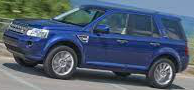

In [4]:
"""image= open_image("./test images/FromInternet/LandRvrLR2SUV2012.jpeg")
#image.px = image.px[:,60:150,40:230]
image.px = image.px[:,y0:y1,x0:x1]
#39 233 65 155 x0,x1,y0,y1
#image.px = image.px[:,0:183,0:275]
image
#show_image(image)"""

### 